## Importing the Data

In [1]:
# Constants
DATASET_DIR = './data/' # Datasets to be places here
SAVE_DIR = './' # Main Dir
WORD2VEC_DIR = './word2vec/' # Pretrained Word2vec model
GOVE_DIR = './glove/' # Pretrained glove model

import os
import pandas as pd
import numpy as np

""" Attribute Reduction """
# Removing empty columns and finding minimum and maximum scores given to each of the 8 sets

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
# Reading from tsv file (tab - separated) with Latin alphabet encoding including special symbols
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
Z = pd.read_excel(r'./data/essay_set_descriptions.xlsx')

minimum_scores = Z['min_domain1_score'].to_list()
minimum_scores.insert(0,-1)
maximum_scores = Z['max_domain1_score'].to_list()
maximum_scores.insert(0,-1)

In [2]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


Minimum and Maximum Scores for each essay set.

In [3]:
print(minimum_scores)
print(maximum_scores)

[-1, 2, 1, 0, 0, 0, 0, 0, 0]
[-1, 12, 6, 3, 3, 4, 4, 30, 60]


## Pre-processing of the Data

These are all helper functions used to clean and tokenize the essays.

In [4]:
# !pip install gensim
# !pip install nltk
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('popular')
import re # for regular expressions operations 
from nltk.corpus import stopwords

def essay_to_wordlist(essay_v, remove_stopwords):
    # remove the tagged labels and word tokenize the sentence
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v) # removing anything that is not alphabetic
    words = essay_v.lower().split() # turn sentence into lowercase and split it into words 
    if remove_stopwords:
        stops = set(stopwords.words("english")) # english stopwords library 
        words = [w for w in words if not w in stops] # words present in the sentence and not present in stopwords
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    # sentence tokenize the essay and call essay_to_wordlist() for word tokenization
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # nltk library
    raw_sentences = tokenizer.tokenize(essay_v.strip()) # call tokenizer on essay striped of spaces 
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
            # remove_stopwords carried forward to essay_to_wordlist it is a bool variable
    return sentences # will be returning list of tokenized sentences without stopwords

## Word2Vec Model

We will preprocess all essays and convert them to feature vectors and will visualize them using tensorflow

In [5]:
from gensim.models import Word2Vec # for word2vec
from gensim.test.utils import get_tmpfile

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    #  make null vectors of length = num_features for every word index
    num_words = 0.
    index2word_set = set(model.wv.index2word) # vocabulary set of model
    for word in words:
        if word in index2word_set: # for word in a sentence being in index2word_set
            num_words += 1
            featureVec = np.add(featureVec,model[word])
    if num_words:
        featureVec = np.divide(featureVec,num_words) 
        # divides every element of featureVec by num_words (to compute average) 
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    # it then calls makeFeatureVec and for every essay sentance
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    # make null vectors of length = length of essay having null vector of num_features at every index
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs
    # then returns the trained model feature vectors
    
allsentences = [] # list of all sentences
    
for essay in X['essay']:
# obtaining all sentences from the essays.
    allsentences += essay_to_sentences(essay, remove_stopwords = True)
            
# initializing variables for word2vec model.
num_features = 300 # vector length
min_word_count = 40 # to be considered for vectorisation
num_workers = 8 # working cores
context = 10
downsampling = 1e-3 # compressing

# for visualization of vectors
visualmodel = Word2Vec(allsentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

path = get_tmpfile("./word2vecvis/word2vecvisual.model") # path for the model 

visualmodel.init_sims(replace=True) # normalized model
# different ways to save model
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.txt', binary=False)
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.bin', binary=True)
visualmodel.save("./word2vecvis/word2vecvisual.model")

## Visualization

In [6]:
# Storing Visual model tsv files
import io # for input output

# for visualization of a stored model
'''from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(SAVE_DIR+'/word2vecmodel.bin', binary=True)'''

# files needed for tensorboard
out_v = io.open('./word2vecvis/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./word2vecvis/meta.tsv', 'w', encoding='utf-8')

# write meta file and vector file
for index in range(len(visualmodel.wv.index2word)): # for every word in vocab
    word = visualmodel.wv.index2word[index]
    vec = visualmodel.wv.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Open http://projector.tensorflow.org/
# Click “Load Data” button from the left menu.
# Select “Choose file” in “Load a TSV file of vectors.” and choose “vecs.tsv” file.
# Select “Choose file” in “Load a TSV file of metadata.” and choose “meta.tsv” file.
# The model has been visualized in 3D/2D.
# It is done on choosing variable with higher variance as a dimension from the vector



In [7]:
M=visualmodel[visualmodel.wv.vocab]
df=pd.DataFrame(M)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.048559,-0.144675,-0.021983,0.007758,-0.008053,0.024640,-0.044620,-0.100529,-0.052203,-0.023801,...,0.046948,0.018901,0.076338,-0.013274,-0.037731,0.154583,-0.003958,-0.071823,0.072195,0.053462
1,0.069540,-0.126001,-0.004412,0.058765,-0.045914,0.039808,-0.033994,-0.064057,-0.074317,0.002762,...,0.034300,0.024217,0.044326,-0.099647,-0.063528,0.098052,-0.044417,0.031473,-0.002426,0.020693
2,0.053180,-0.117936,-0.030335,0.036868,0.013269,0.081977,-0.041989,-0.093823,-0.083053,-0.008933,...,0.040743,0.033276,0.063567,-0.066758,-0.036938,0.105261,-0.003978,-0.005875,0.020178,0.076266
3,0.033333,-0.093217,0.126422,-0.025054,-0.002745,0.105345,-0.013656,-0.061211,-0.054798,-0.010839,...,0.002762,-0.044449,0.109974,-0.067489,-0.049399,-0.119328,0.057436,-0.066016,-0.025470,0.078741
4,0.035092,-0.106345,0.010947,0.032412,0.025194,0.014121,-0.066634,-0.028346,-0.031479,0.057246,...,-0.010923,-0.043114,0.026767,-0.000003,-0.101261,-0.024019,0.055262,-0.064707,0.049464,0.115261



 300.00000000000034

1. Variance Explained
 [13.429629409875684, 10.317774340440696, 7.746220294723116, 6.695640204064983, 5.773715720161583]

2. Cumulative Variance Explained
 [13.42962941 23.74740375 31.49362405 38.18926425 43.96297997]

 [[-0.19032346 -0.01613678]
 [-0.06213822 -0.15806142]
 [-0.26010009 -0.21197481]
 ...
 [ 0.56651475 -0.24596526]
 [ 0.38012128 -0.25564157]
 [ 0.18360254 -0.07886354]]


<BarContainer object of 5 artists>

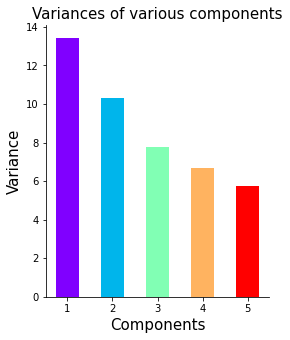

In [94]:
#Computing the correlation matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
M_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(M_corr)

"""
Sorting the eigen vectors coresponding to eigen values in descending order
is done like this to have us choosing best eigenvector for infogain.
But in our model its already sorted the way it should be.
Eigenvector with highest eigenvalue in the first column.

args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]
"""

# our aim is to cover maximum variance possible 
# no. of components selected = no. of plotting dimensions
tot = sum(values) # summation of eigenvalues
print("\n",tot) 
var_exp = [(i / tot)*100 for i in values[:5]] # first 5 variance in desc order
print("\n1. Variance Explained\n",var_exp) 
cum_var_exp = np.cumsum(var_exp) # first 5 cumulative variance
print("\n2. Cumulative Variance Explained\n",cum_var_exp) 
# as we can see % of variance the first two principal components each contain 13 , 12
# these components together contain 23

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

new_M=np.dot(M,new_vectors)
print("\n",new_M) # coordinates for 2D plot

plt.figure(figsize=(8,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Variances of various components',size=15)
plt.xlabel("Components",size=15)
plt.ylabel('Variance',size=15)
plt.bar(range(1,6),
        var_exp,
        width=0.8,
        color = cm.rainbow(np.linspace(0, 1, len(var_exp))))

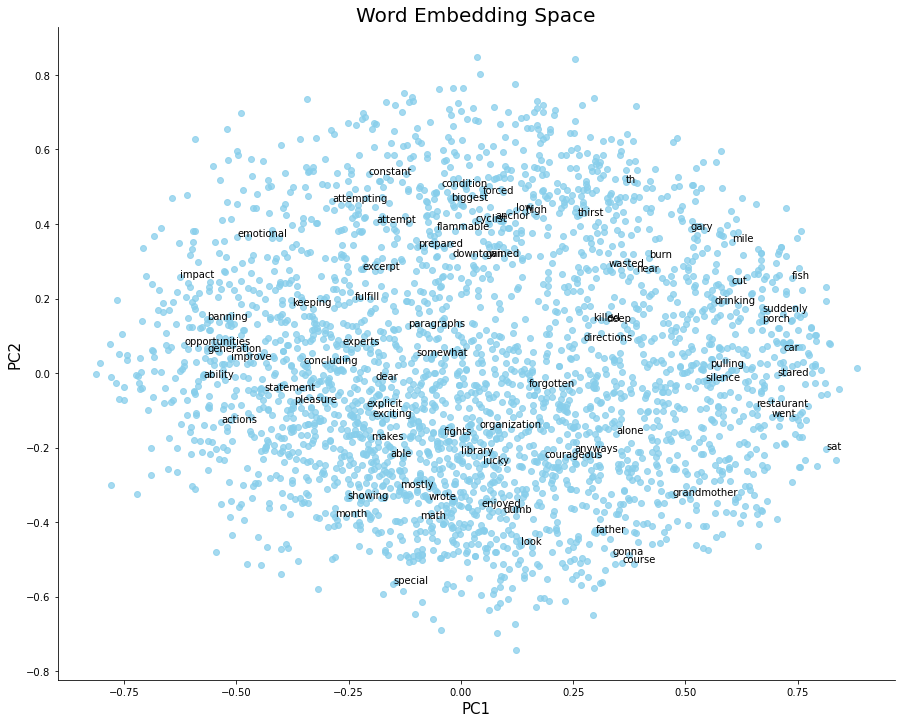

In [80]:
#Plotting
plt.figure(figsize=(15,12))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(new_M[:,0],new_M[:,1],linewidths=1,color='skyblue',alpha=0.75)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(visualmodel.wv.vocab)
for i, word in enumerate(vocab):
  if i%37==0:
      plt.annotate(word,xy=(new_M[i,0],new_M[i,1])) # selective annotations
  

## Defining the model 

Here we define a 2-Layer LSTM Model. 

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [10]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

"""
def get_model():
    Define the model.
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
"""

"\ndef get_model():\n    Define the model.\n    model = Sequential()\n    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))\n    model.add(LSTM(64, recurrent_dropout=0.4))\n    model.add(Dropout(0.5))\n    model.add(Dense(1, activation='relu'))\n\n    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])\n    model.summary()\n\n    return model\n"

## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [11]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score


cv = KFold(n_splits=5, shuffle=True)
cv.get_n_splits(X)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.txt', binary=False)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 8 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1
        


--------Fold 1--------



KeyboardInterrupt: 

The Avg. Kappa Score is 0.961 which is the highest we have ever seen on this dataset.

In [9]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9584
